In [1]:
from csv import reader
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
#from sklearn.matrics import precision_score, recall_score
import pandas as pd

In [2]:
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

<class 'float'>
(1372, 4)
<class 'numpy.ndarray'>


,Variance Wavelet,Skewness Wavelet,Curtosis Wavelet,Entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


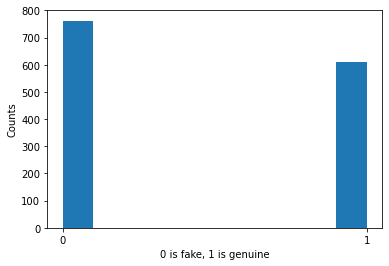

In [3]:
df = load_csv('data_banknote_authentication.txt')

for i in range(len(df)):
  for j in range(4):
    df[i][j] = float(df[i][j])

print(type(df[0][0]))
X = np.array([df[0][0:4]])
y = np.array([df[0][4]])

for i in range(1, len(df)):
  tmp = np.array([])
  for j in range(len(df[0])):
    if (j == 4):
      y = np.append(y, df[i][j])
      continue
    tmp = np.append(tmp, df[i][j])
  X = np.vstack([X, tmp])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('0 is fake, 1 is genuine')
ax.set_ylabel('Counts')
ax.hist(y)
print(np.shape(X))
print(type(X))
d = {'Variance Wavelet':pd.Series(X[:,0]),
     'Skewness Wavelet':pd.Series(X[:,1]),
   'Curtosis Wavelet':pd.Series(X[:,2]),
   'Entropy':pd.Series(X[:,3]),
   'IsFake': pd.Series(y)}

df = pd.DataFrame(d)
df.head()
df.describe()

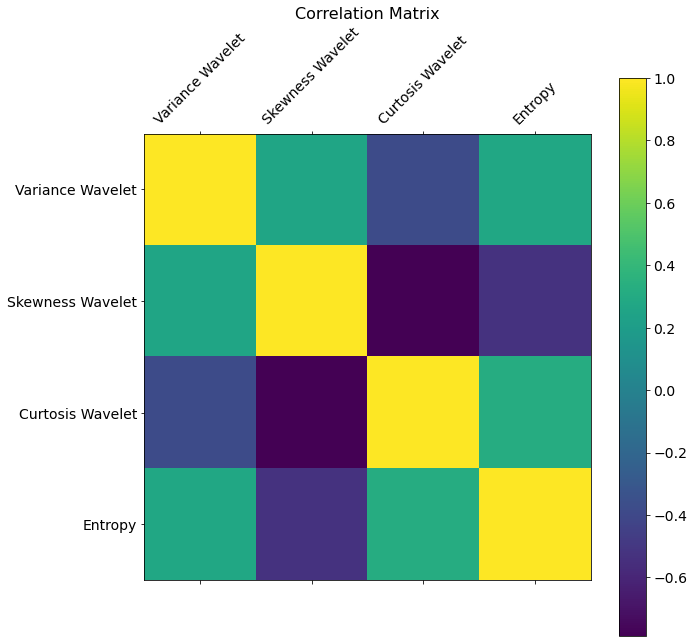

In [4]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [5]:
class NaiveBayesClassifier:

    def __init__(self):
        pass

    # Separate the dataset into a subset of data for each class

    def separate_classes(self, X, y):
        """
        Separates the dataset in to a subset of data for each class.
        Parameters:
        ------------
        X- array, list of features
        y- list, target
        Returns:
        A dictionary with y as keys and assigned X as values.
        """
        separated_classes = {}
        for i in range(len(X)):
            feature_values = X[i]
            class_name = y[i]
            if class_name not in separated_classes:
                separated_classes[class_name] = []
            separated_classes[class_name].append(feature_values)
        return separated_classes

    # Standard deviation and mean are required for the (Gaussian) distribution function

    def stat_info(self, X):
        """
        Calculates standard deviation and mean of features.
        Parameters:
        ------------
        X- array , list of features
        Returns:
        A dictionary with STD and Mean as keys and assigned features STD and Mean as values.
        """
        for feature in zip(*X):
            yield {
                'std' : np.std(feature),
                'mean' : np.mean(feature)
            }
            
    # Required fit method, to train the model

    def fit (self, X, y):
        """
        Trains the model.
        Parameters:
        ----------
        X: array-like, training features
        y: list, target variable
        Returns:
        Dictionary with the prior probability, mean, and standard deviation of each class
        """

        separated_classes = self.separate_classes(X, y)
        self.class_summary = {}

        for class_name, feature_values in separated_classes.items():
            self.class_summary[class_name] = {
                'prior_proba': len(feature_values)/len(X),
                'summary': [i for i in self.stat_info(feature_values)],
            }
        return self.class_summary

    # Gaussian distribution function

    def distribution(self, x, mean, std):
        """
        Gaussian Distribution Function
        Parameters:
        ----------
        x: float, value of feature
        mean: float, the average value of feature
        stdev: float, the standard deviation of feature
        Returns:
        A value of Normal Probability
        """

        exponent = np.exp(-((x-mean)**2 / (2*std**2)))

        return exponent / (np.sqrt(2*np.pi)*std)

    # Required predict method, to predict the class

    def predict(self, X):
        """
        Predicts the class.
        Parameters:
        ----------
        X: array-like, test data set
        Returns:
        -----------
        List of predicted class for each row of data set
        """

        # Maximum a posteriori (MAP)
        
        MAPs = []

        for row in X:
            joint_proba = {}
            
            for class_name, features in self.class_summary.items():
                total_features =  len(features['summary'])
                likelihood = 1

                for idx in range(total_features):
                    feature = row[idx]
                    mean = features['summary'][idx]['mean']
                    stdev = features['summary'][idx]['std']
                    normal_proba = self.distribution(feature, mean, stdev)
                    likelihood *= normal_proba
                prior_proba = features['prior_proba']
                joint_proba[class_name] = prior_proba * likelihood

            MAP = max(joint_proba, key= joint_proba.get)
            MAPs.append(MAP)

        return MAPs
    
    # Calculate the model's accuracy

    def accuracy(self, y_test, y_pred):
        """
        Calculates model's accuracy.
        Parameters:
        ------------
        y_test: actual values
        y_pred: predicted values
        Returns:
        ------------
        A number between 0-1, representing the percentage of correct predictions.
        """

        true_true = 0

        for y_t, y_p in zip(y_test, y_pred):
            if y_t == y_p:
                true_true += 1 
        return true_true / len(y_test)

In [6]:
# def split_data(data, weight):
#     """
#     Random split of a data set into training and test data sets
    
#     Parameters:
#     -----------
#     data: array-like, dataset
#     weight: float, percentage of data to be used as training
    
#     Returns:
#     List of two datasets
#     """
#     train_length = int(len(data) * weight)
#     train = []
#     for i in range(train_length):
#         idx = random.randrange(len(data))
#         train.append(data[idx])
#         data.pop(idx)
#     return [train, data]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# train, test = split_data(df, 0.8)
# X_train = []
# y_train = []
# X_test = []
# y_test = []

# for i in range(len(train)):
#     y_train.append(train[i][4])
#     X_train.append(train[i][0:4])
    
# for i in range(len(test)):
#     y_test.append(test[i][4])
#     X_test.append(test[i][0:4])

model = NaiveBayesClassifier()
model.fit(X_train, y_train)
y_pred_own = model.predict(X_test)

print("NaiveBayesClassifier accuracy: {0:.3f}".format(model.accuracy(y_test, y_pred_own)))

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Scikit-learn GaussianNB accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))
#print('Precision: %.3f' % precision_score(y_test, y_pred,average="micro"))
#print('Recall: %.3f' % recall_score(y_test, y_pred,average="micro"))

NaiveBayesClassifier accuracy: 0.845
Scikit-learn GaussianNB accuracy: 0.845


In [7]:
from sklearn. metrics import roc_auc_score, roc_curve

r_auc = roc_auc_score(y_test, y_pred)
r_auc_own = roc_auc_score(y_test, y_pred_own)
print(r_auc)

0.8435374149659864


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


<ipython-input-8-86ee9f13222c>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(type(y_pred[0].astype(np.int)))


<class 'numpy.int32'>


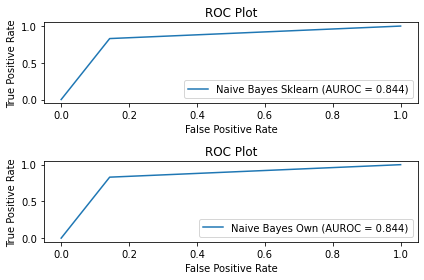

In [8]:
y_pred_conv = []
y_test_conv = []
y_pred_conv_own = []
for i in range(len(y_test)):
  y_test_conv.append(int(y_test[i]))
  y_pred_conv.append(y_pred[i].astype(np.int64))
  y_pred_conv_own.append(y_pred_own[i].astype(np.int64))


print(type(y_pred[0].astype(np.int)))
fpr, tpr, _ = roc_curve(y_test_conv, y_pred_conv)
fpr_own, tpr_own, _ = roc_curve(y_test_conv, y_pred_conv_own)

fig, axs = plt.subplots(2)
axs[0].plot(fpr, tpr, label='Naive Bayes Sklearn (AUROC = %0.3f)' % r_auc)
axs[1].plot(fpr_own, tpr_own, label='Naive Bayes Own (AUROC = %0.3f)' % r_auc_own)

axs[0].set_title("ROC Plot")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")

axs[1].set_title("ROC Plot")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

fig.tight_layout()
    
axs[0].legend()
axs[1].legend()
plt.show()